In [1]:
import os
import joblib

import pandas as pd

from pathlib import Path
from tqdm import tqdm
from model_settings import ms
from plotters import PlotCols
import matplotlib.pyplot as plt

ms.find_root(Path())

# functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def CompareDists(X,Y):
    bins=int(np.sqrt(min(len(X),len(Y))))
    try:
        xlabel = X.name.replace('_',' ')
    except Exception:
        xlabel = ''
    try:
        ylabel = Y.name.replace('_',' ')
    except Exception:
        ylabel = ''
    plt.figure()
    plt.hist(X,bins=bins,label=xlabel,density=True,color='green')
    plt.hist(Y,bins=bins,label=ylabel,density=True,color='purple',histtype='step')
    plt.legend()
    plt.show()import numpy as np


# loading model

In [3]:
root = os.path.join(ms.root)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 112825652640 cboe spx relative asian
1     2024-11-09 124653897492 cboe spx relative barrier


In [4]:
selected_model = models.iloc[0]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
pricename = f"{selected_model[selected_model.rfind(' ')+1:]}_price"
initial = model['model']
model

{'seed': 1312,
 'raw_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 0           1274.0        637.00                 7        1.0   
 1           1274.0        637.00                 7        1.0   
 2           1274.0        637.00                 7        1.0   
 3           1274.0        637.00                 7        1.0   
 4           1274.0        955.50                 7        1.0   
 ...            ...           ...               ...        ...   
 338935      5857.0       7320.75                84        1.0   
 338936      5857.0       8785.00                84        1.0   
 338937      5857.0       8785.00                84        1.0   
 338938      5857.0       8785.00                84        1.0   
 338939      5857.0       8785.00                84        1.0   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                      7             0      geometric  call        0.001578   
 1                 

In [5]:
pricename

'asian_price'

In [6]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

fixing frequency: 
0     7
1    28
2    84
Name: fixing_frequency, dtype: int64

past fixings: 
0    0
Name: past_fixings, dtype: int64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e-09
            ...     
1747    6.161121e+01
1748    6.214923e+01
1749    6.690466e+01
1750    8.814194e+01
1751    1.158504e+02
Name: kappa, Length: 1752, dtype: float64

th

In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])
model['numerical_features']

['days_to_maturity', 'fixing_frequency', 'past_fixings', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'relative_spot', 'averaging_type', 'w']


['days_to_maturity',
 'fixing_frequency',
 'past_fixings',
 'risk_free_rate',
 'dividend_rate',
 'kappa',
 'theta',
 'rho',
 'eta',
 'v0',
 'relative_spot']

In [9]:
test_dates = model['test_dates']
full_dataset = model['dataset']
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')

retraining_frequency = 20

n = model['test_dates'].shape[0]//retraining_frequency

In [10]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame()

models = {}

for i in range(0,n):
    development_dates = pd.to_datetime(model['development_dates'],format='mixed')
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    subset_test = full_dataset[full_dataset['date'].isin(subset_test_dates)]
    target = subset_test['relative_observed']
    prediction = initial.predict(subset_test[model['feature_set']])
    error = prediction-target
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    df.at[date,'avgsqrtv0'] = np.mean(np.sqrt(subset_test['v0']))
    for col in ['rho','theta','spot_price']:
        df.at[date,f"avg_{col}"] = np.mean(subset_test['rho'])

df.index = pd.to_datetime(df.index)
df

,outofsample_MAE,outofsample_RMSE,avgsqrtv0,avg_rho,avg_theta,avg_spot_price
2012-11-06,0.005963,0.009630,0.249055,-0.753334,-0.753334,-0.753334
2013-02-04,0.003528,0.005019,0.184722,-0.770896,-0.770896,-0.770896
2013-04-25,0.003267,0.004914,0.196642,-0.680760,-0.680760,-0.680760
2013-06-10,0.003656,0.005622,0.247043,-0.767547,-0.767547,-0.767547
2013-08-09,0.003320,0.004916,0.165528,-0.714034,-0.714034,-0.714034
...,...,...,...,...,...,...
2023-08-31,2.873988,2.904735,0.228525,-0.714251,-0.714251,-0.714251
2023-11-08,2.724340,2.755863,0.218752,-0.695387,-0.695387,-0.695387
2024-01-25,2.644957,2.671264,0.278784,-0.615904,-0.615904,-0.615904
2024-03-26,2.727722,2.756128,0.229676,-0.635111,-0.635111,-0.635111


['outofsample_MAE', 'outofsample_RMSE', 'avgsqrtv0', 'avg_rho', 'avg_theta', 'avg_spot_price']


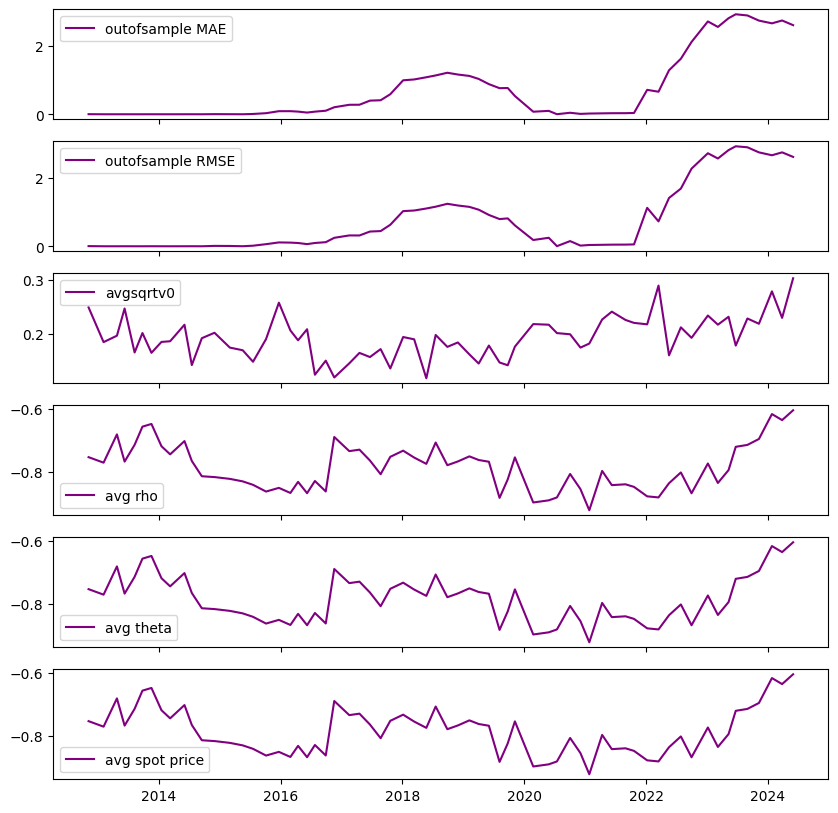

In [11]:
PlotCols(df,figsize=(10,10))

In [12]:
test_data = model['test_data'].copy()

test_data['sqrtv0'] = np.sqrt(test_data['v0'])
sqrtv0 = test_data['sqrtv0']
quants = sqrtv0.describe()[3:]
quants

min    0.010116
25%    0.111623
50%    0.153286
75%    0.244846
max    0.780206
Name: sqrtv0, dtype: float64

In [13]:
test_data[['v0','sqrtv0','relative_spot',]].describe()

,v0,sqrtv0,relative_spot
count,315360.000000,315360.000000,315360.000000
mean,0.056290,0.194906,1.160153
std,0.083109,0.135286,0.476408
min,0.000102,0.010116,0.666667
25%,0.012460,0.111623,0.800000
50%,0.023497,0.153286,1.000095
75%,0.059950,0.244846,1.333660
max,0.608722,0.780206,2.001458


In [14]:
print(test_data.dtypes)

spot_price                       float64
strike_price                     float64
days_to_maturity                   int64
n_fixings                        float64
fixing_frequency                   int64
past_fixings                       int64
averaging_type                    object
w                                 object
risk_free_rate                   float64
dividend_rate                    float64
calculation_date          datetime64[ns]
kappa                            float64
theta                            float64
rho                              float64
eta                              float64
v0                               float64
date                      datetime64[ns]
asian_price                      float64
relative_spot                    float64
relative_asian_price             float64
relative_observed                float64
outofsample_target               float64
outofsample_prediction           float64
outofsample_error                float64
sqrtv0          

In [15]:
test_data['observed_price'] = test_data['relative_observed']*test_data['strike_price']
test_data['relative_error'] = test_data['observed_price']/test_data[pricename]-1

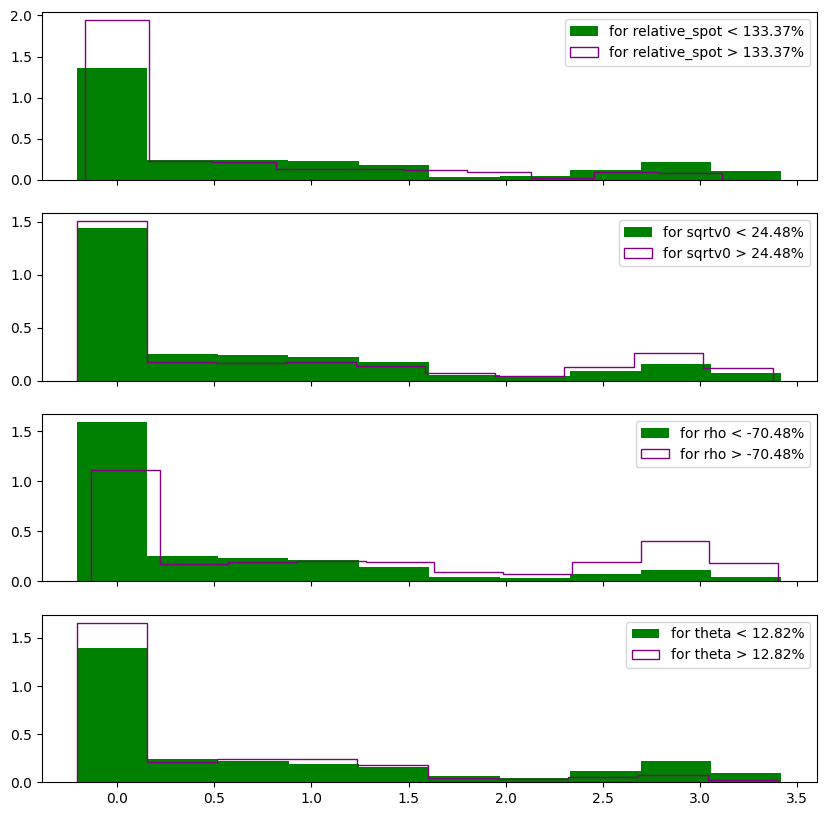

In [16]:
num_features = ['relative_spot','sqrtv0','rho','theta']
test_variable = [
    # 'relative_error',
    'outofsample_error'
][0]
bins = 10

fig,axs=plt.subplots(len(num_features),figsize=(10,10),sharex=True)
for i,f in enumerate(num_features):
    subdesc = test_data[f].describe()
    subp75 = subdesc['75%']
    normal_vol = test_data[test_data[f]<=subp75]
    high_vol = test_data[test_data[f]>subp75]
    axs[i].hist(normal_vol[test_variable],density=True,bins=bins,label=f'for {f} < {round(100*subp75,2)}%',color='green')
    axs[i].hist(high_vol[test_variable],density=True,bins=bins,label=f'for {f} > {round(100*subp75,2)}%',color='purple',histtype='step')
    axs[i].legend()
plt.show()

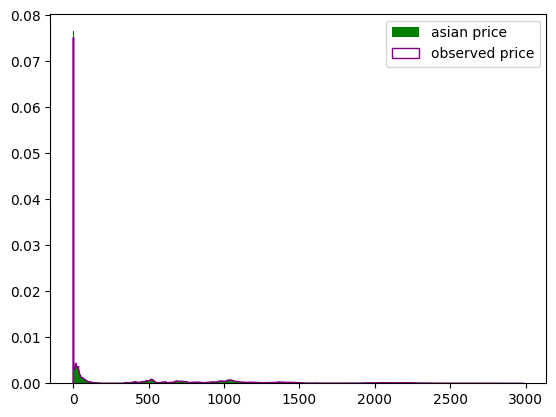

In [17]:
CompareDists(test_data[pricename],test_data['observed_price'])

In [18]:
test_data[[pricename,'observed_price']].describe()

,asian_price,observed_price
count,315360.000000,315360.000000
mean,456.365970,456.361147
std,650.611386,650.662033
min,0.000000,0.000000
25%,0.000000,0.000000
50%,32.922283,32.920511
75%,854.445047,856.282212
max,2931.600979,2986.733307


In [19]:
print(f"MARE: {round(100*np.mean(np.abs(test_data['relative_error'])),6)}%")

MARE: 0.798194%


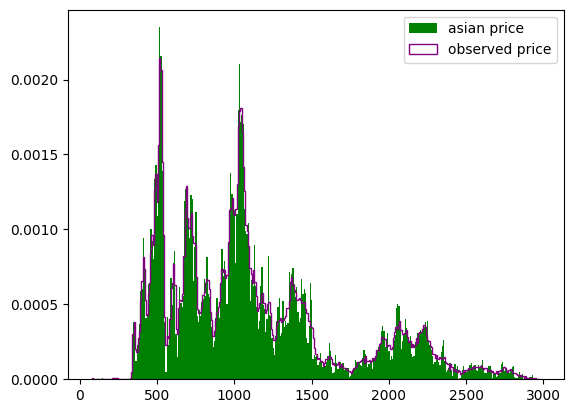

In [20]:
zoomed = test_data[test_data[pricename]>0.05*test_data['spot_price']]

CompareDists(zoomed[pricename],zoomed['observed_price'])